In [21]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Arc
from typing import NamedTuple, Tuple

In [8]:
# from sklearn.mixture import GaussianMixture

In [22]:
"""Mixture model based on kmeans"""
from typing import Tuple
# from common import GaussianMixture


def estep(X: np.ndarray, mixture: GaussianMixture) -> np.ndarray:
    """E-step: Assigns each datapoint to the gaussian component with the
    closest mean

    Args:
        X: (n, d) array holding the data
        mixture: the current gaussian mixture

    Returns:
        np.ndarray: (n, K) array holding the soft counts
            for all components for all examples

        """
    n, _ = X.shape
    K, _ = mixture.mu.shape
    post = np.zeros((n, K))

    for i in range(n):
        tiled_vector = np.tile(X[i, :], (K, 1))
        sse = ((tiled_vector - mixture.mu)**2).sum(axis=1)
        j = np.argmin(sse)
        post[i, j] = 1

    return post


def mstep(X: np.ndarray, post: np.ndarray) -> Tuple[GaussianMixture, float]:
    """M-step: Updates the gaussian mixture. Each cluster
    yields a component mean and variance.

    Args: X: (n, d) array holding the data
        post: (n, K) array holding the soft counts
            for all components for all examples

    Returns:
        GaussianMixture: the new gaussian mixture
        float: the distortion cost for the current assignment
    """
    n, d = X.shape
    _, K = post.shape

    n_hat = post.sum(axis=0)
    p = n_hat / n

    cost = 0
    mu = np.zeros((K, d))
    var = np.zeros(K)

    for j in range(K):
        mu[j, :] = post[:, j] @ X / n_hat[j]
        sse = ((mu[j] - X)**2).sum(axis=1) @ post[:, j]
        cost += sse
        var[j] = sse / (d * n_hat[j])

    return GaussianMixture(mu, var, p), cost


def run(X: np.ndarray, mixture: GaussianMixture,
        post: np.ndarray) -> Tuple[GaussianMixture, np.ndarray, float]:
    """Runs the mixture model

    Args:
        X: (n, d) array holding the data
        post: (n, K) array holding the soft counts
            for all components for all examples

    Returns:
        GaussianMixture: the new gaussian mixture
        np.ndarray: (n, K) array holding the soft counts
            for all components for all examples
        float: distortion cost of the current assignment
    """

    prev_cost = None
    cost = None
    while (prev_cost is None or prev_cost - cost > 1e-4):
        prev_cost = cost
        post = estep(X, mixture)
        mixture, cost = mstep(X, post)

    return mixture, post, cost

In [23]:
class GaussianMixture(NamedTuple):
    """Tuple holding a gaussian mixture"""
    mu: np.ndarray  # (K, d) array - each row corresponds to a gaussian component mean
    var: np.ndarray  # (K, ) array - each row corresponds to the variance of a component
    p: np.ndarray  # (K, ) array = each row corresponds to the weight of a component


def init(X: np.ndarray, K: int,
         seed: int = 0) -> Tuple[GaussianMixture, np.ndarray]:
    """Initializes the mixture model with random points as initial
    means and uniform assingments

    Args:
        X: (n, d) array holding the data
        K: number of components
        seed: random seed

    Returns:
        mixture: the initialized gaussian mixture
        post: (n, K) array holding the soft counts
            for all components for all examples

    """
    np.random.seed(seed)
    n, _ = X.shape
    p = np.ones(K) / K

    # select K random points as initial means
    mu = X[np.random.choice(n, K, replace=False)]
    var = np.zeros(K)
    # Compute variance
    for j in range(K):
        var[j] = ((X - mu[j])**2).mean()

    mixture = GaussianMixture(mu, var, p)
    post = np.ones((n, K)) / K

    return mixture, post


def plot(X: np.ndarray, mixture: GaussianMixture, post: np.ndarray,
         title: str):
    """Plots the mixture model for 2D data"""
    _, K = post.shape

    percent = post / post.sum(axis=1).reshape(-1, 1)
    fig, ax = plt.subplots()
    ax.title.set_text(title)
    ax.set_xlim((-20, 20))
    ax.set_ylim((-20, 20))
    r = 0.25
    color = ["r", "b", "k", "y", "m", "c"]
    for i, point in enumerate(X):
        theta = 0
        for j in range(K):
            offset = percent[i, j] * 360
            arc = Arc(point,
                      r,
                      r,
                      0,
                      theta,
                      theta + offset,
                      edgecolor=color[j])
            ax.add_patch(arc)
            theta += offset
    for j in range(K):
        mu = mixture.mu[j]
        sigma = np.sqrt(mixture.var[j])
        circle = Circle(mu, sigma, color=color[j], fill=False)
        ax.add_patch(circle)
        legend = "mu = ({:0.2f}, {:0.2f})\n stdv = {:0.2f}".format(
            mu[0], mu[1], sigma)
        ax.text(mu[0], mu[1], legend)
    plt.axis('equal')
    plt.show()


# def rmse(X, Y):
#     return np.sqrt(np.mean((X - Y)**2))

# def bic(X: np.ndarray, mixture: GaussianMixture,
#         log_likelihood: float) -> float:
#     """Computes the Bayesian Information Criterion for a
#     mixture of gaussians

#     Args:
#         X: (n, d) array holding the data
#         mixture: a mixture of spherical gaussian
#         log_likelihood: the log-likelihood of the data

#     Returns:
#         float: the BIC for this mixture
#     """
#     raise NotImplementedError

In [30]:
def run_kmeans(K):
    for i in range(1,K):
        min_cost = None
        best_seed = None
        for seed in range(1,K):
            mixture, post = init(X, i, seed)
            mixture, post, cost = run(X, mixture, post)
            if min_cost is None or cost < min_cost:
                min_cost = cost
                best_seed = seed
        mixture, post = init(X, i, best_seed)
        mixture, post, cost = run(X, mixture, post)
        title = "K-means for K={},seed={},cost={}".format(i,best_seed,min_cost)
        plot(X, mixture, post, title)

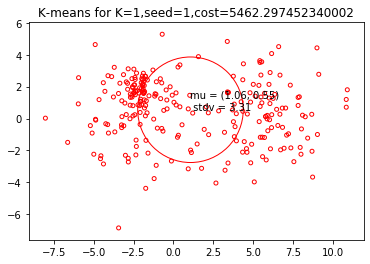

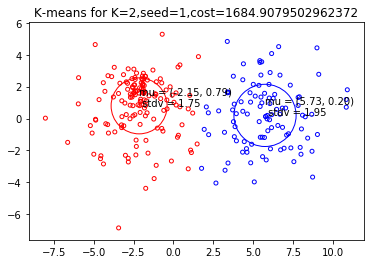

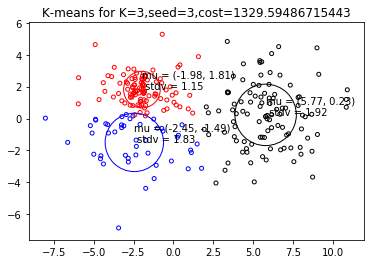

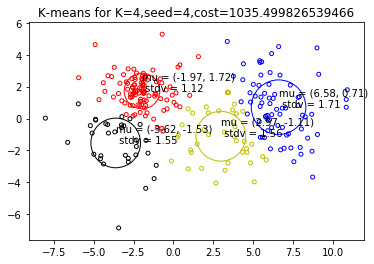

In [31]:
run_kmeans(5)

In [4]:
X = np.loadtxt("toy_data.txt")

In [5]:
X

array([[-1.636,  2.413],
       [-2.957,  2.296],
       [-2.871,  1.832],
       [-2.696,  1.327],
       [-2.272,  1.738],
       [-2.393,  1.729],
       [-1.762,  2.649],
       [-2.598,  1.345],
       [-2.02 ,  2.239],
       [-2.398,  2.449],
       [-2.414,  2.569],
       [-2.545,  1.94 ],
       [-0.735,  2.233],
       [-2.379,  1.711],
       [-1.895,  1.823],
       [-1.849,  2.499],
       [-2.602,  2.498],
       [-3.13 ,  2.749],
       [-1.913,  2.1  ],
       [-2.433,  2.104],
       [-2.124,  1.92 ],
       [-1.072,  2.302],
       [-2.481,  3.094],
       [-1.844,  1.635],
       [-2.035,  1.075],
       [-1.865,  1.608],
       [-2.703,  1.533],
       [-1.537,  1.423],
       [-1.809,  1.69 ],
       [-1.176,  1.403],
       [-2.877,  2.207],
       [-1.834,  1.168],
       [-1.831,  2.069],
       [-1.917,  2.175],
       [-2.482,  1.634],
       [-1.917,  1.738],
       [-1.946,  2.662],
       [-1.765,  2.648],
       [-2.604,  1.462],
       [-1.998,  0.881],
